# Trabalho de AEDV (A1)
   
#### Dupla dinâmica: $(igor)^2 = -(gor)^2$
    Igor Cortes Junqueira
    Igor Patricio Michels

## Escolha da base de dados

O primeiro passo do trabalho foi a escolha da base de dados. Para tanto optamos por otimizar o tempo fazendo a escolha de uma base que pode nos porporcionar a escolha da próxima série a ser assistida. Dessa forma, escolhemos uma base do Kaggle com séries em diversas plataformas, a qual pode ser encontrada [aqui](https://www.kaggle.com/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney).

Um problema dessa base é que ela não é muito informativa, isto é, uma das informações que consideramos de maior relevância, o gênero da série, não está presente nessa base. Dessa forma, buscamos novas bases de dados no Kaggle, uma da [Netflix](https://www.kaggle.com/shivamb/netflix-shows), uma da [Amazon Prime](https://www.kaggle.com/nilimajauhari/amazon-prime-tv-shows) e uma da [Disney Plus](https://www.kaggle.com/unanimad/disney-plus-shows), as quais possuem a indicação do gênero.

Para utilizar as 4 bases descritas, realizamos um merge entre elas a partir do título, incluindo o gênero da série na nossa base. As demais informações presentes nas últimas 3 bases foram descartadas, uma vez que nem todas tinham aquela informação. Da base original descartamos todos os títulos que estavam presentes apenas na plataforma Hulu, uma vez que esta plataforma não está disponível no Brasil.

Abaixo temos a preparação do ambiente, com a importação das bibliotecas utilizadas, bem como a importação das bancos de dados.

## Importação e limpeza dos dados

In [79]:
library(readr)
library(stringr)
library(rlist)
library(dplyr)
library(ggplot2)
shows <- read_csv("tv_shows.csv")
disney <- read_csv("disney_plus_shows.csv")
netflix <- read_csv("netflix_titles.csv")
prime <- read_csv("Prime TV Shows Data set.csv")

Parsed with column specification:
cols(
  ID = col_character(),
  Title = col_character(),
  Year = col_double(),
  Age = col_character(),
  IMDb = col_double(),
  Rotten_Tomatoes = col_character(),
  Netflix = col_double(),
  Hulu = col_double(),
  Prime_Video = col_double(),
  DisneyPlus = col_double(),
  type = col_double()
)
Warning message:
"85 parsing failures.
row col   expected    actual           file
 63  -- 11 columns 1 columns 'tv_shows.csv'
 69  -- 11 columns 1 columns 'tv_shows.csv'
423  -- 11 columns 1 columns 'tv_shows.csv'
453  -- 11 columns 1 columns 'tv_shows.csv'
528  -- 11 columns 1 columns 'tv_shows.csv'
... ... .......... ......... ..............
See problems(...) for more details.
"Parsed with column specification:
cols(
  imdb_id = col_character(),
  title = col_character(),
  plot = col_character(),
  type = col_character(),
  rated = col_character(),
  year = col_character(),
  released_at = col_character(),
  added_at = col_character(),
  runtime = col_chara

Feito isso, iremos compor a base do trabalho, isto é, fazer o merge dos bancos utilizados, bem como a exclusão das séries exclusivas da Hulu.

In [80]:
# Limpando o databse conjunto para os dados relevantes

cshows <- shows %>% mutate(Streamings = paste(sep = " ", ifelse(Netflix == 1, "Netflix", ""),
                                                         ifelse(Prime_Video == 1, "Prime", ""),
                                                         ifelse(DisneyPlus == 1, "Disney", "")) %>%
                                        trimws() %>%
                                        str_replace(" ",", ")) %>%
                                        select(-Netflix, -Hulu, -Prime_Video, -DisneyPlus, -type, -ID)

cshows <- subset(cshows, Streamings != "NA, NA NA" & Streamings != "")
cshows <- cshows %>% mutate(Rotten_Tomatoes = as.numeric(sub("%", "", Rotten_Tomatoes)))

# Importanto Genero dos demais databases

t1 <- netflix %>% mutate(Title = title, Genre = listed_in) %>% select(Title, Genre) 
t2 <- prime %>% mutate(Title = ) %>% select(Title, Genre)
t3 <- disney %>% mutate(Title = title, Genre = genre) %>% select(Title, Genre)
gb <- c("Title", "Genre")
t <- full_join(t1, full_join(t2, t3, by = gb), by = gb)

cshows <- left_join(cshows, t, by = 'Title')
glimpse(cshows)

Rows: 4,143
Columns: 7
$ Title           <chr> "Breaking Bad", "Stranger Things", "Money Heist", "She~
$ Year            <dbl> 2008, 2016, 2017, 2010, 2015, 2005, 2011, 2005, 2005, ~
$ Age             <chr> "18+", "16+", "18+", "16+", "18+", "16+", "18+", "16+"~
$ IMDb            <dbl> 9.5, 8.8, 8.4, 9.1, 8.7, 8.9, 8.8, 8.4, 8.4, 8.8, 9.2,~
$ Rotten_Tomatoes <dbl> 96, 93, 91, 78, 97, 81, 83, 93, 93, 92, 100, 81, 94, 8~
$ Streamings      <chr> "Netflix", "Netflix", "Netflix", "Netflix", "Netflix",~
$ Genre           <chr> "Crime TV Shows, TV Dramas, TV Thrillers", "TV Horror,~


Como utilizamos 3 bases distintas para incluir o gênero da série, é natural que o gênero esteja totalmente despadronizado, dessa forma estamos criando uma lista de gêneros para facilitar nossas queries.

In [81]:
x <- ""
for(g in cshows[,'Genre'][[1]]){
    c <- str_replace_all(g,"TV","") %>%
         str_replace_all("Reality-", "Reality-Show") %>%
         str_replace_all("Sci-Fi", "Sci-fi") %>%
         str_replace_all("Sci-fi comedy", "") %>%
         str_replace_all(" &", ",") %>%
         str_replace_all("Movies", "") %>%
         str_replace_all("Shows", "") %>%
         str_replace_all("/", "") %>%
         str_replace_all("Mysteries", "Mystery") %>%
         str_replace_all("Comedies", "Comedy") %>%
         str_replace_all("Documentaries", "Documentary") %>%
         str_replace_all("Dramas", "Drama") %>%
         str_replace_all("Musicals", "Musical") %>%
         str_replace_all("Thrillers", "Thriller") %>%
         str_replace_all("Talk-Show", "") %>%
         str_replace_all("Romantic", "Romance") %>%
         str_replace_all("Anime Series", "Anime") %>%
         str_replace_all("Kids\'", "") %>%
         str_replace_all("Kids\'", "")

    x <- paste(x, trimws(c), sep = ",")
}

gens <- strsplit(x, ",")[[1]] %>%
        trimws() %>%
        unique()

gens <- gens[gens != ""]
gens

[1] "Crime"            "Drama"            "Thriller"         "Horror"          
 [5] "Mystery"          "Sci-fi"           "Fantasy"          "NA"              
 [9] "British"          "International"    "Comedy"           "Classic"         
[13] "Cult"             "Action"           "Adventure"        "Suspense"        
[17] "Anime"            "Romance"          "Spanish-Language" "Teen"            
[21] "Docuseries"       "Science"          "Nature"           "Reality"         
[25] "Documentary"      "Sports"           "Korean"           "Animation"       
[29] "Family"           "Musical"          "Independent"      "Stand-Up Comedy" 
[33] "Talk"             "Reality-Show"     "Game-Show"        "Kids"            
[37] "Children"         "Short"            "Music"            "Western"         
[41] "LGBTQ"            "Arts"             "Entertainment"    "Culture"

## Análise Exploratória

In [132]:
plataforma <- table(cshows$Streamings)
plataforma


          Disney          Netflix Netflix,  Disney   Netflix, Prime 
             186             1832                8               93 
           Prime 
            2024 

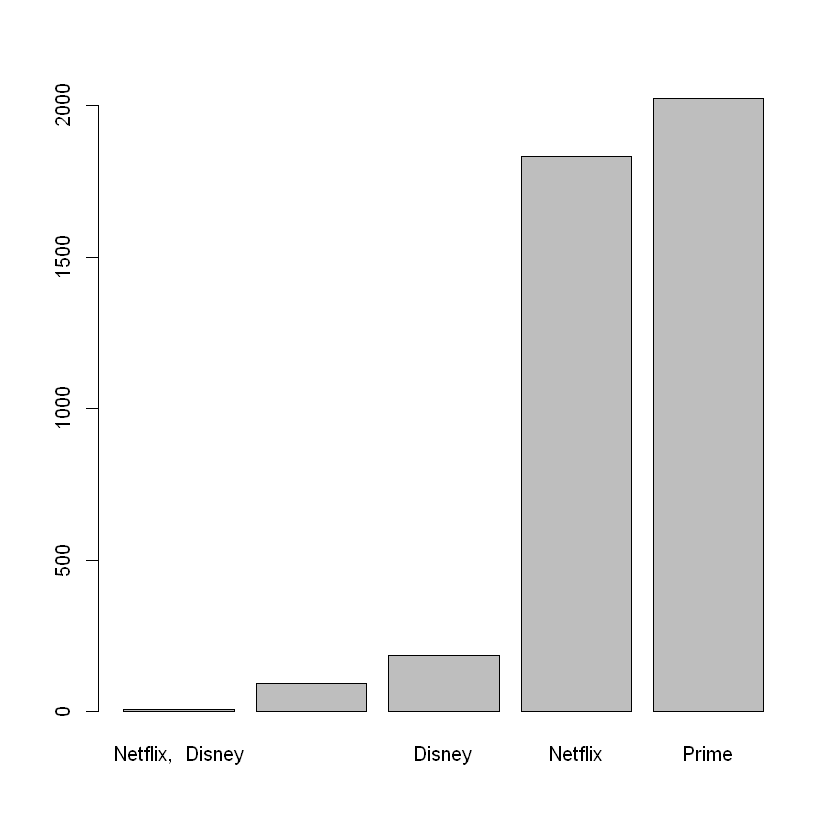

In [133]:
barplot(sort(plataforma))

In [134]:
plataforma <- prop.table(plataforma)
plataforma


          Disney          Netflix Netflix,  Disney   Netflix, Prime 
     0.044895004      0.442191649      0.001930968      0.022447502 
           Prime 
     0.488534878 

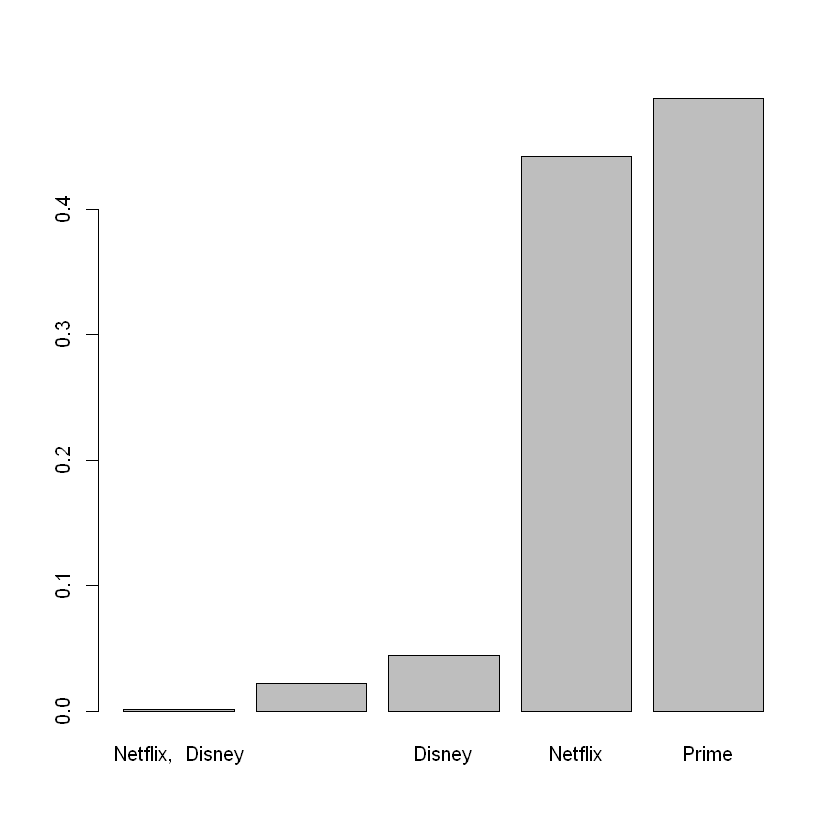

In [135]:
barplot(sort(plataforma))

Note que mais que 50% das séries disponíveis se encontram no Amazon Prime (48.85% da Amazon Prime e 2.24% que estão na Netflix e na Amazon Prime). Outro fato interessante é que o Disney Plus tem menos que 5% das séries e, além disso, nenhuma série se encontra no Disney Plus e na Amazon Prime simultaneamente.

Um outro dado de nosso interesse é a avaliação da crítica, dessa forma, analisando as notas, temos os seguintes quantis.

In [136]:
quantile(cshows[, "IMDb"], na.rm = TRUE)

0%  25%  50%  75% 100% 
 1.0  6.6  7.4  8.0  9.5

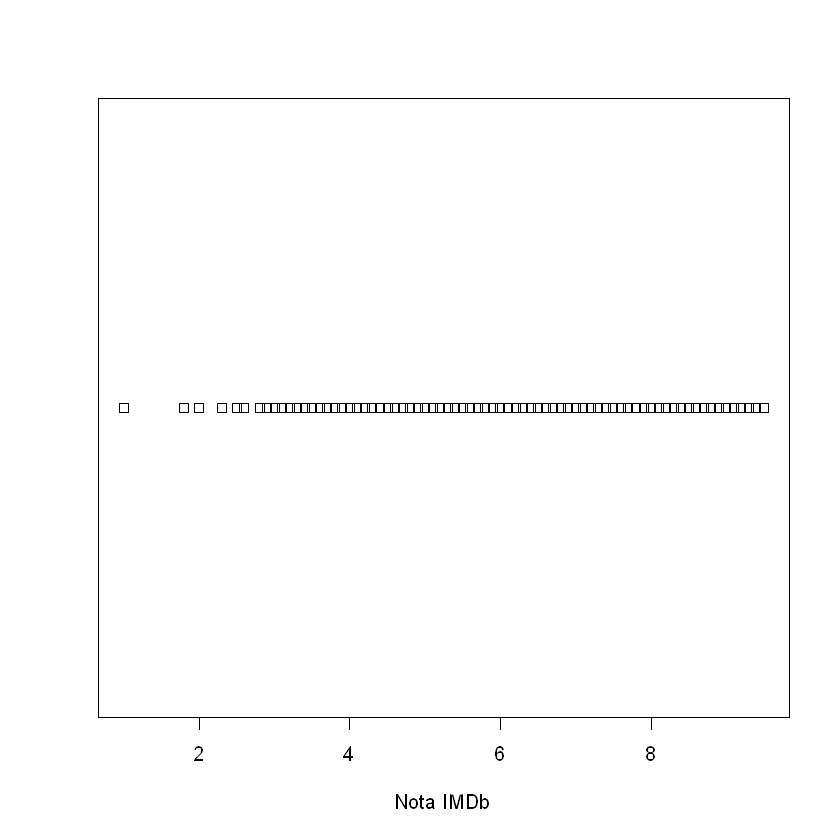

In [137]:
stripchart(cshows[, "IMDb"], xlab = "Nota IMDb")

Warning message:
"Removed 938 rows containing non-finite values (stat_boxplot)."

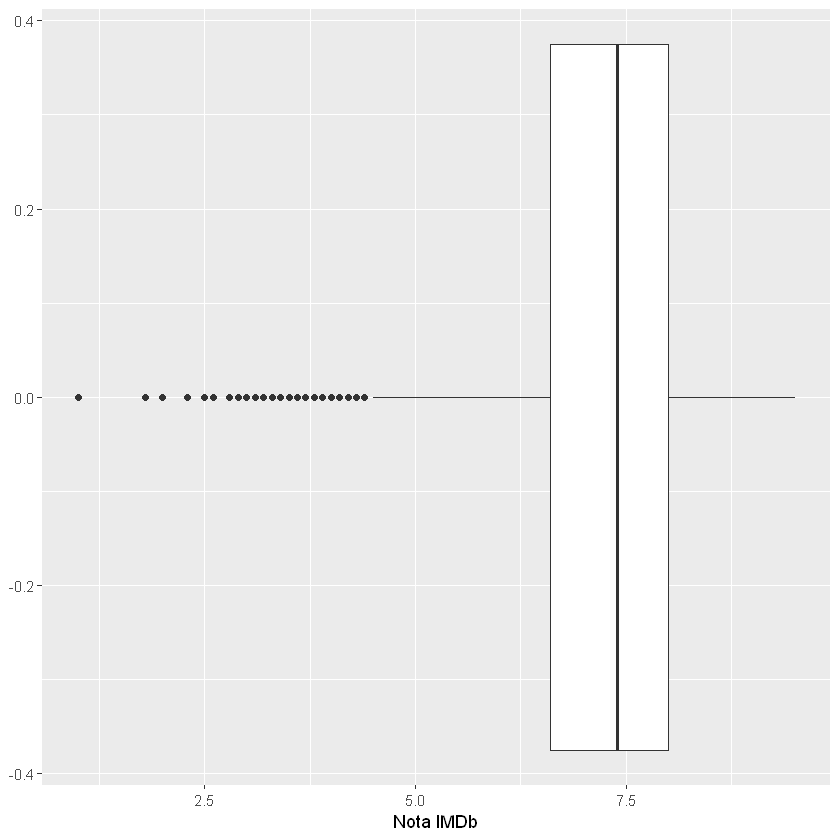

In [138]:
cshows %>% 
ggplot(aes(x = IMDb)) +
geom_boxplot() +
labs(x = "Nota IMDb")

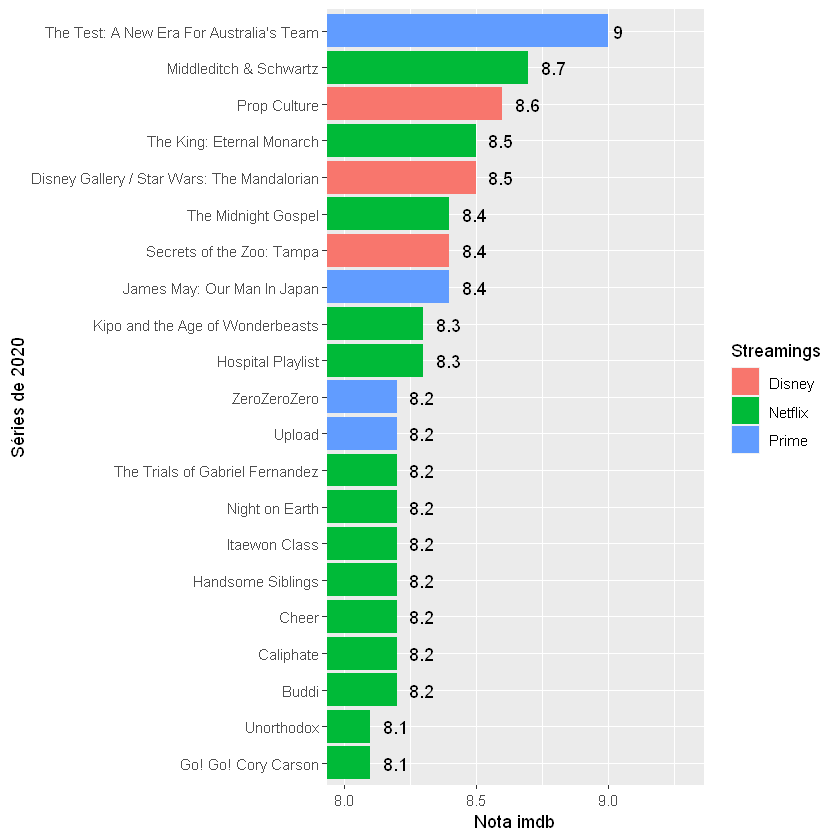

In [139]:
# Melhores séries de 2020 pelo IMDb (nota > 8)
cshows %>% filter(Year==2020, IMDb>8) %>% arrange(-IMDb) %>%
    ggplot(aes(reorder(Title,IMDb),IMDb)) + geom_col(aes(fill=Streamings)) +
    coord_flip(ylim=c(8,9.3)) + xlab("Séries de 2020") + ylab("Nota imdb") +
    geom_text(aes(label = IMDb), hjust = -.5)

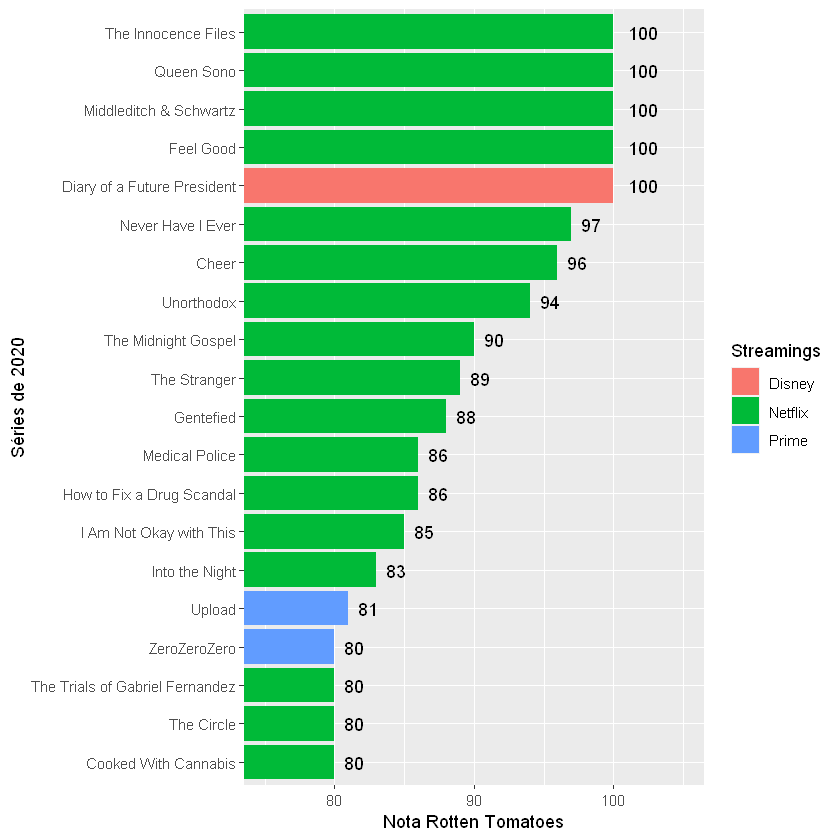

In [140]:
# Melhores séries de 2020 pelo Rotten Tomatoes (nota > 80)
cshows %>% filter(Year==2020, Rotten_Tomatoes>=80) %>%
    ggplot(aes(reorder(Title,Rotten_Tomatoes),Rotten_Tomatoes)) + geom_col(aes(fill=Streamings)) +
    coord_flip(ylim=c(75,105)) + xlab("Séries de 2020") + ylab("Nota Rotten Tomatoes") +
    geom_text(aes(label = Rotten_Tomatoes), hjust = -.5)

In [152]:
plataforma <- table(cshows$Streamings, cshows$Age)
plataforma

                  
                   13+ 16+ 18+  7+ all
  Disney             0   3   0  71  82
  Netflix            3 394 355 271 151
  Netflix,  Disney   0   0   0   4   4
  Netflix, Prime     0  17   4  26  17
  Prime              1 196 177 196 174

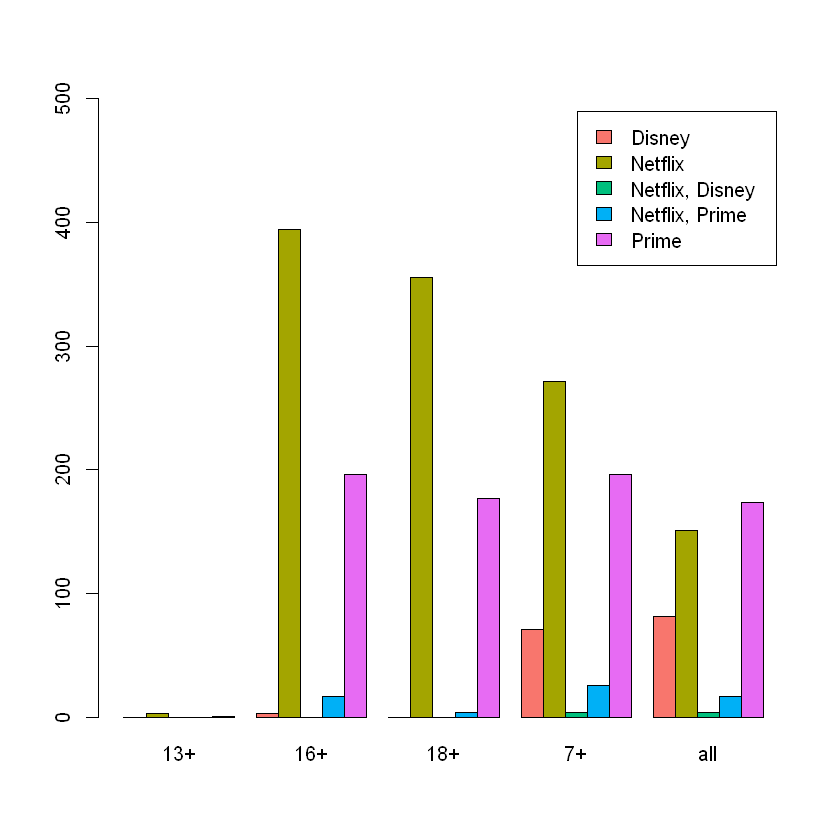

In [160]:
barplot(plataforma,
        beside = TRUE,
        legend.text = c("Disney", "Netflix", "Netflix, Disney", "Netflix, Prime", "Prime"),
        col = c("#f8766d", "#a3a500", "#00bf7d", "#00b0f6", "#e76bf3"),
        ylim = c(0, 500))

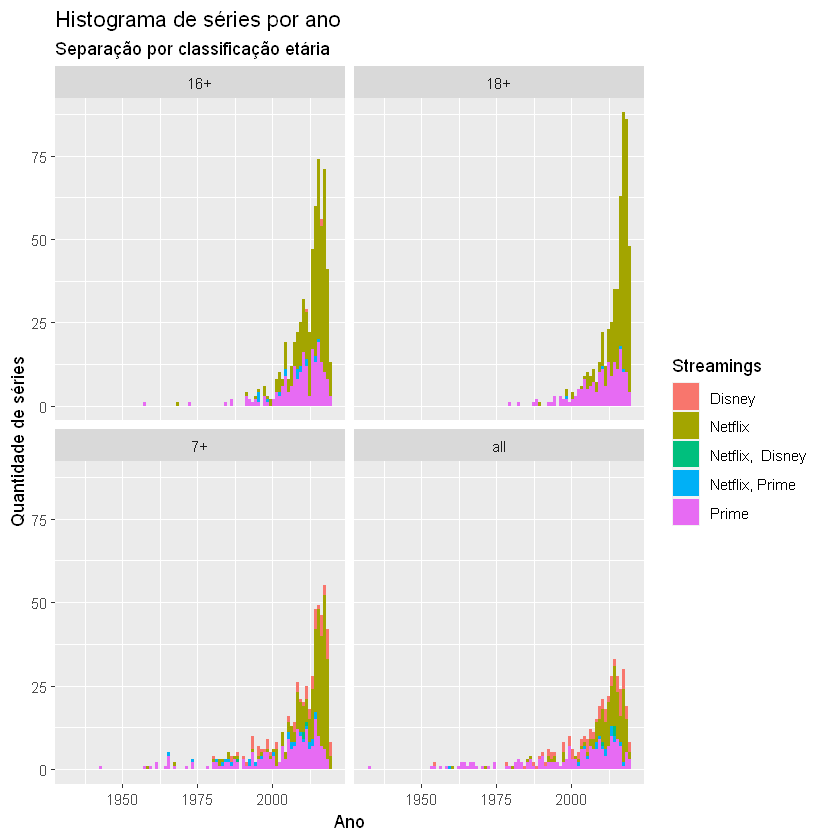

In [113]:
# Séries por ano, por faixa etária. Tirei idades 13+ (poucas séries) NA (não informativo)
cshows %>% 
filter(Age != "13+", Age != "NA") %>% 
    ggplot(aes(x = Year, fill = Streamings)) +
    geom_histogram(binwidth = 1, boundary = 0) +
    facet_wrap(~ Age, ncol = 2)+ 
    labs(x = "Ano",
    y = "Quantidade de séries",
    title = "Histograma de séries por ano",
    subtitle = "Separação por classificação etária")

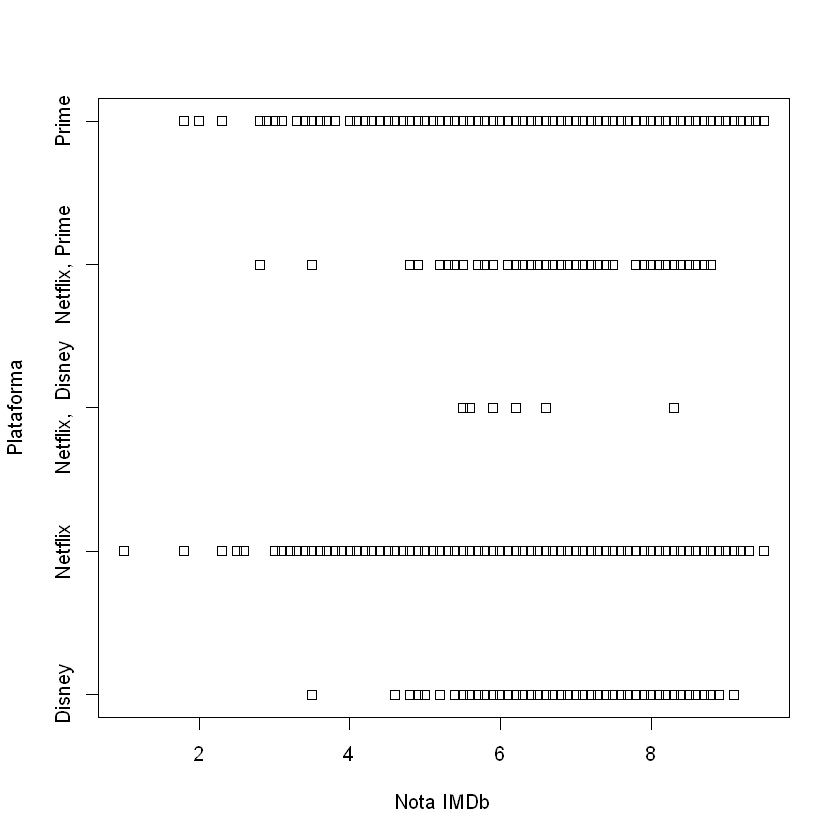

In [165]:
stripchart(cshows$IMDb ~ cshows$Streamings, xlab = "Nota IMDb", ylab = "Plataforma")

Warning message:
"Removed 938 rows containing non-finite values (stat_boxplot)."

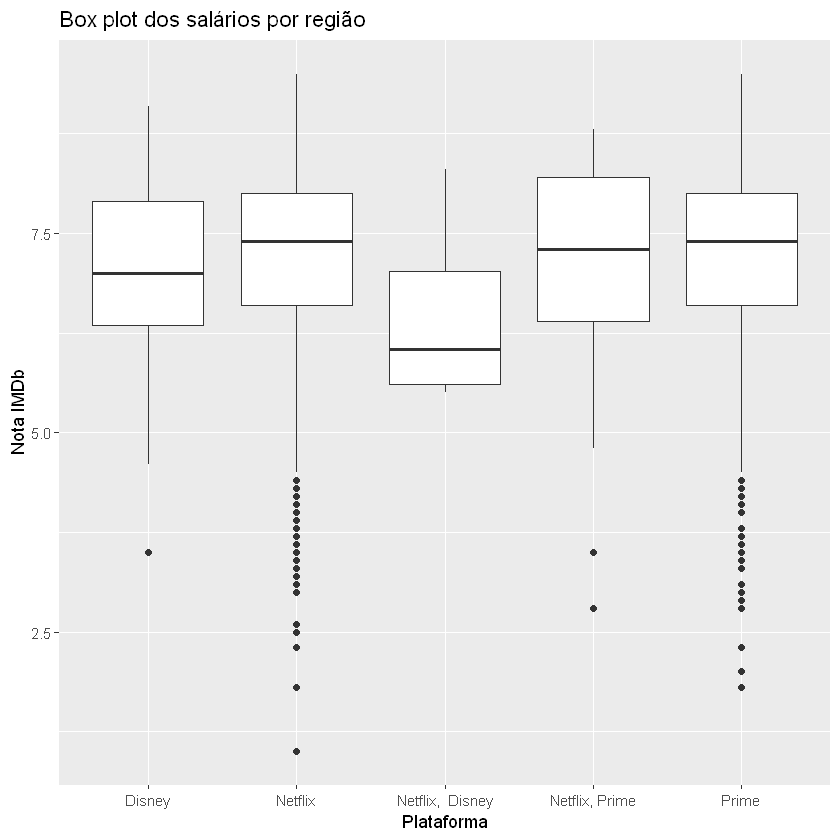

In [167]:
cshows %>% 
ggplot(aes(x = Streamings, y = IMDb)) +
geom_boxplot() +
# geom_jitter(color = "red") + 
labs(x = "Plataforma",
y = "Nota IMDb",
title = "Box plot dos salários por região")

Warning message:
"Removed 3430 rows containing missing values (geom_point)."

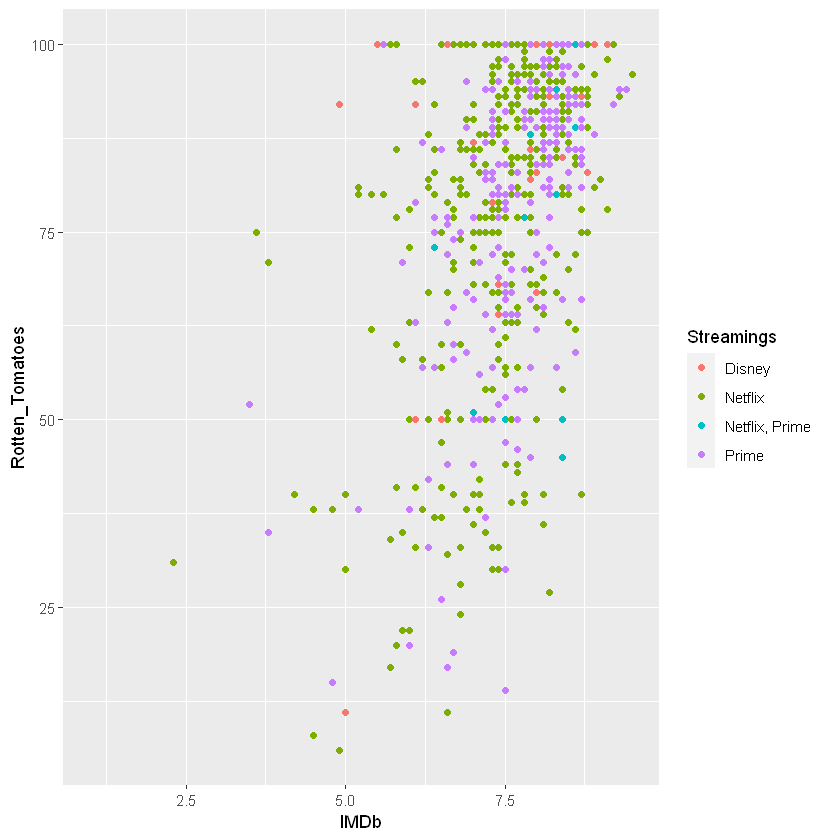

In [172]:
cshows %>% filter(Streamings != "Netflix,  Disney") %>% 
ggplot(aes(x = IMDb, y = Rotten_Tomatoes, color = Streamings)) +
geom_point()

Warning message:
"Removed 3430 rows containing missing values (geom_point)."

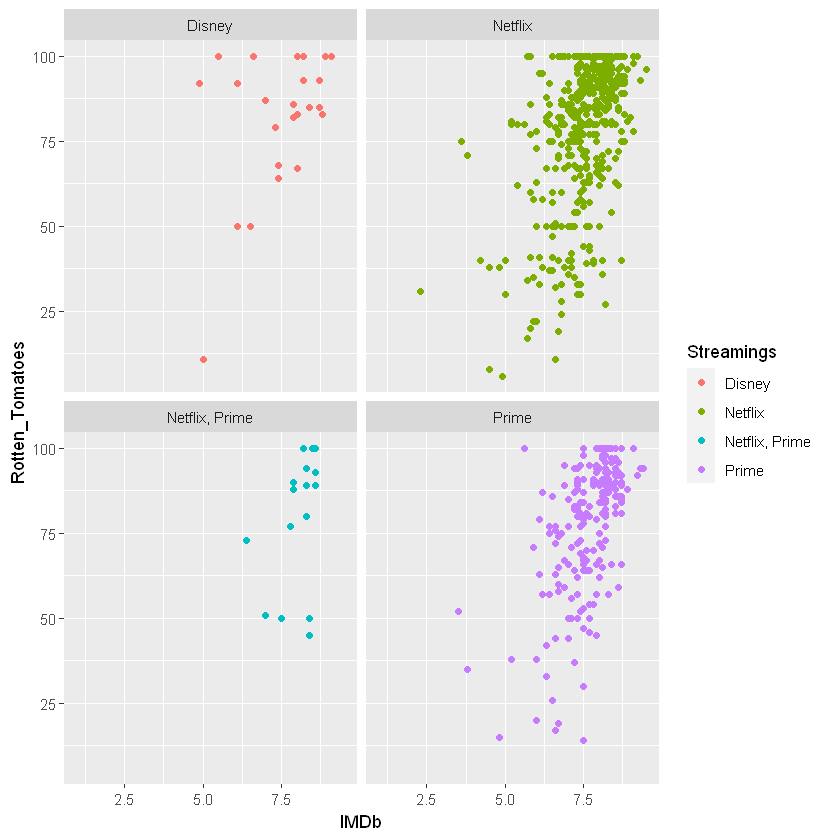

In [171]:
cshows %>% filter(Streamings != "Netflix,  Disney") %>% 
ggplot(aes(x = IMDb, y = Rotten_Tomatoes, color = Streamings)) +
geom_point() +
facet_wrap(~ Streamings, ncol = 2)

In [91]:
glimpse(cshows)

Rows: 4,143
Columns: 7
$ Title           <chr> "Breaking Bad", "Stranger Things", "Money Heist", "She~
$ Year            <dbl> 2008, 2016, 2017, 2010, 2015, 2005, 2011, 2005, 2005, ~
$ Age             <chr> "18+", "16+", "18+", "16+", "18+", "16+", "18+", "16+"~
$ IMDb            <dbl> 9.5, 8.8, 8.4, 9.1, 8.7, 8.9, 8.8, 8.4, 8.4, 8.8, 9.2,~
$ Rotten_Tomatoes <dbl> 96, 93, 91, 78, 97, 81, 83, 93, 93, 92, 100, 81, 94, 8~
$ Streamings      <chr> "Netflix", "Netflix", "Netflix", "Netflix", "Netflix",~
$ Genre           <chr> "Crime TV Shows, TV Dramas, TV Thrillers", "TV Horror,~
